In [1]:
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

def color_string(order, s : str):
    if order in [6, 8]:
        return bcolors.FAIL + s + bcolors.ENDC
    else:
        return s

# Catan Structure
## Tile
    - Gift
    - Sea
    - Uncharted
    - Harbor

    every tile has draw() method
    Gift is fundamental piece for this map generator. After generating the map, type and number of every each gift should be assigned.
    Both of Sea and Uncharted are not resource so they don't have type or number, but Uncharted has potential to be resource and they have a diffferent draw() method.
    Harbor is dependent on Gift and has resource type but don't have number and coordinate.


In [2]:
from __future__ import annotations
from typing import List, Dict, Tuple
from abc import ABC, abstractmethod
from enum import Enum

import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon, Polygon

class CatanObjectType(Enum):
    Gift = 0
    Harbor = 1

class CatanGiftType(Enum):
    Default = -1
    Resource = 0
    Sea = 1
    Uncharted = 2

class ResourceType(Enum):
    
    @classmethod
    def list(cls):
        return list(cls._member_map_.values())

    Default = -1
    Tree = 0
    Grain = 1
    Steel = 2
    Sheep = 3
    Ground = 4

class HarborType(Enum):

    @classmethod
    def list(cls):
        return list(cls._member_map_.values())
        
    Default = -1
    Tree = 0
    Grain = 1
    Steel = 2
    Sheep = 3
    Ground = 4
    ThreeToOne = 5

# Use "Visitor" design pattern for drawing each CatanObject
# Visitor is a behavioral design pattern that lets you separate algorithms from the objects on which they operate.
    
class CatanObject(ABC):
    def __init__(self, type: CatanObjectType):
        self._type = type
    
    @abstractmethod
    def draw(self, obj: DrawVistor):
        pass

class Gift(CatanObject):
    def __init__(self, coord: tuple, type=CatanGiftType.Default):
        super().__init__(CatanObjectType.Gift)
        self.gift_type = type
        self.coord = coord

    def adjacent(self) -> List[tuple]:
        row, col = self.coord
        return [
            (row+1, col),
            (row, col+1),
            (row-1, col+1),
            (row-1, col),
            (row, col-1),
            (row+1, col-1)
        ]

    def draw(self, obj: DrawVistor):
        obj.draw_default(self)

class Resource(Gift):
    odds = {
        -1 : 0,
        2 : 1,
        3 : 2,
        4 : 3,
        5 : 4,
        6 : 5,
        8 : 5,
        9 : 4,
        10 : 3,
        11 : 2,
        12 : 1
    }
    
    def __init__(self, coord: tuple, number: int=-1, resource_type = ResourceType.Default):
        assert(number in Resource.odds.keys())
        super().__init__(coord, CatanGiftType.Resource)
        self.number = number
        self.odd = Resource.odds[self.number]
        self.resource_type = resource_type
    
    def draw(self, obj: DrawVistor):
        obj.draw_resource(self)

class Sea(Gift):
    def __init__(self, coord: tuple):
        super().__init__(coord, CatanGiftType.Sea)
    
    def draw(self, obj: DrawVistor):
        obj.draw_sea(self)

class Uncharted(Gift):
    def __init__(self, coord: tuple):
        super().__init__(coord, CatanGiftType.Uncharted)
        
    def draw(self, obj: DrawVistor):
        obj.draw_uncharted(self)

class Harbor(CatanObject):
    def __init__(self, resource: Resource, edge=-1, harbor_type=HarborType.Default):
        super().__init__(CatanObjectType.Harbor)
        self.resource = resource
        self.type = harbor_type
        self.edge = edge
    
    def draw(self, obj: DrawVistor):
        obj.draw_harbor(self)

class DrawVistor(ABC):
    def __init__(self):
        self.fig, self.ax = None, None

    @abstractmethod
    def draw_default(self, obj: Gift):
        pass

    @abstractmethod
    def draw_resource(self, obj: Resource):
        pass

    @abstractmethod
    def draw_sea(self, obj: Sea):
        pass

    @abstractmethod
    def draw_uncharted(self, obj: Uncharted):
        pass

    @abstractmethod
    def draw_harbor(self, obj: Harbor):
        pass    

    def reset(self):
        self.fig, self.ax = plt.subplots(1)
        self.ax.set_aspect('equal')

    def display(self):
        plt.autoscale(enable = True)
        plt.show()

In [3]:
import numpy as np
import math

class CatanDrawingObject(DrawVistor):
    def __init__(self, radius = np.sqrt(1/3)):
        super().__init__()
        self.radius = radius

    def __transform(self, row: int, col: int):
        
        x = (2 * col + row) * self.radius * math.cos(math.radians(30))
        y = row * 3 / 2 * self.radius
        
        return x, y

    def draw_default(self, obj: Gift):
        hex = RegularPolygon(self.__transform(*obj.coord), numVertices=6, radius=self.radius, alpha=1, edgecolor='k', facecolor='k')
        self.ax.add_patch(hex)
        plt.text(*self.__transform(*obj.coord), "{}".format(obj.coord), fontsize = 15, ha='center', va='center', color='w')

    def draw_resource(self, obj: Resource):
        fc, tc, t, w = 'w', 'k', '{}\n'.format(obj.number) + '.' * obj.odd, 'normal'

        if obj.resource_type == ResourceType.Tree:
            fc = 'green'
            tc = "k"
        elif obj.resource_type == ResourceType.Grain:
            fc = 'gold'
            tc = "k"
        elif obj.resource_type == ResourceType.Steel:
            fc = 'steelblue'
            tc = "w"
        elif obj.resource_type == ResourceType.Sheep:
            fc = 'lime'
            tc = "k"
        elif obj.resource_type == ResourceType.Ground:
            fc = 'brown'
            tc = "w"
        else:
            fc = 'w'
            tc = "b"
            t = ""
        
        if obj.number == 6 or obj.number == 8:
            w = 'bold'
            tc = 'red'
            
        hex = RegularPolygon(self.__transform(*obj.coord), numVertices=6, radius=self.radius, alpha=1, edgecolor='k', facecolor=fc)
        self.ax.add_patch(hex)
        plt.text(*self.__transform(*obj.coord), t, fontsize = 15, ha='center', va='center', color=tc, weight=w)
        
    def draw_sea(self, obj: Sea):
        hex = RegularPolygon(self.__transform(*obj.coord), numVertices=6, radius=self.radius, alpha=1, edgecolor='k', facecolor='blue')
        self.ax.add_patch(hex)
        
    def draw_uncharted(self, obj: Uncharted):
        hex = RegularPolygon(self.__transform(*obj.coord), numVertices=6, radius=self.radius, alpha=1, edgecolor='k', facecolor='w')
        self.ax.add_patch(hex)
        plt.text(*self.__transform(*obj.coord), "?", fontsize = 15, ha='center', va='center', color='k')
        
    def draw_harbor(self, obj: Harbor):
        row, col = obj.resource.coord
        x, y = self.__transform(row, col)
        vertices = [
            (x, y + self.radius), 
            (x + self.radius * math.cos(math.radians(30)), y + self.radius * math.cos(math.radians(60))),
            (x + self.radius * math.cos(math.radians(30)), y - self.radius * math.cos(math.radians(60))),
            (x, y - self.radius),
            (x - self.radius * math.cos(math.radians(30)), y - self.radius * math.cos(math.radians(60))),
            (x - self.radius * math.cos(math.radians(30)), y + self.radius * math.cos(math.radians(60)))
        ]

        vertex = [
            (row+1, col),
            (row, col+1),
            (row-1, col+1),
            (row-1, col),
            (row, col-1),
            (row+1, col-1)
        ]

        first_point, second_point, thrid_point = vertices[obj.edge], vertices[(obj.edge+1)%6], self.__transform(*vertex[obj.edge])
        fc, tc, t = 'violet', 'k', ''
        if obj.type == HarborType.Tree:
            fc = 'green'
            tc = "k"
        elif obj.type == HarborType.Grain:
            fc = 'gold'
            tc = "k"
        elif obj.type == HarborType.Steel:
            fc = 'steelblue'
            tc = "w"
        elif obj.type == HarborType.Sheep:
            fc = 'lime'
            tc = "k"
        elif obj.type == HarborType.Ground:
            fc = 'brown'
            tc = "w"
        elif obj.type == HarborType.ThreeToOne:
            fc = 'bisque'
            tc = "k"
            t = '3:1'

        triangle = Polygon([first_point, second_point, thrid_point], facecolor=fc)
        self.ax.add_patch(triangle)
        middle_point = list(sum(axis) / 3 for axis in zip(*[first_point, second_point, thrid_point]))
        plt.text(*middle_point, t, fontsize = 15, ha='center', va='center', color=tc)

In [4]:
from collections import Counter
import random

random.seed(0)

class Board(ABC):
    def __init__(self, size: tuple):
        assert(len(size) == 2)
        assert(all(s > 0 for s in size))
        self.size = size
        self.drawer = CatanDrawingObject()

        self.default : Dict[Gift] = {}
        self.resources : Dict[Resource] = {}
        self.seas : Dict[Sea] = {}
        self.uncharted : Dict[Uncharted] = {}
        self.harbors : Dict[Harbor] = {}
        
        rows, cols = self.size
        for row in range(rows):
            for col in range(cols):
                self.default[(row, col)] = Gift(coord=(row, col))
    
    def draw(self, default_gift=True):
        self.drawer.reset()
        if default_gift:
            for gift in self.default.values():
                gift.draw(self.drawer)

        for resource in self.resources.values():
            resource.draw(self.drawer)

        for sea in self.seas.values():
            sea.draw(self.drawer)

        for uncharted in self.uncharted.values():
            uncharted.draw(self.drawer)

        for harbor in self.harbors.values():
            harbor.draw(self.drawer)
        self.drawer.display()

    @abstractmethod
    def generate(self, resource_types: Counter, dice_numbers: Counter) -> bool:
        pass
    
class FogIsland(Board):
    def __init__(self):
        size = (8, 8)
        super().__init__(size)
        
        resource_coords = [
                    (0, 4), (0, 5), (0, 6),
                    (1, 2), (1, 3), (1, 4), (1, 5), (1, 6),
                    (2, 5), (2, 6),
                    (6, 0), (6, 1), (6, 2), (6, 3),
                    (7, 0), (7, 1), (7, 2),
        ]
    
        uncharted_coords = [
                        (3, 0), (3, 1), (3, 2), (3, 3),
                        (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6),
                        (5, 5)
        ]
        
        sea_coords = [
            (0, 3),
            (2, 1), (2, 2), (2, 3), (2, 4),
            (3, 4), (3, 5), (3, 6),
            (5, 0), (5, 1), (5, 2), (5, 3), (5, 4),
            (6, 4),
            (7, 3)
        ]

        harbor_locations = [
            (6, 3, 0), (7, 2, 5), (7, 0, 0), (7, 0, 4),
            (2, 6, 2), (0, 6, 1), (0, 6, 3), (0, 4, 2), (1, 2, 2)
        ]
        
        for row, col in resource_coords:
            self.resources[(row, col)] = Resource(coord=(row, col))
            del self.default[(row,col)]
        
        for row, col in uncharted_coords:
            self.uncharted[(row, col)] = Uncharted(coord=(row, col))
            del self.default[(row,col)]
            
        for row, col in sea_coords:
            self.seas[(row, col)] = Sea(coord=(row, col))
            del self.default[(row,col)]
        
        for row, col, edge in harbor_locations:
            self.harbors[(row,col,edge)] = Harbor(self.resources[(row,col)], edge)

    def __type_test(self, candidate: Resource) -> bool:
        if candidate is None:
            return True

        # neighbors = [self.resources.get(coord, Resource(coord)) for coord in candidate.adjacent()]
        # target_type = candidate.resource_type
        # if (neighbors[0].resource_type == target_type and neighbors[1].resource_type == target_type) \
        # or (neighbors[1].resource_type == target_type and neighbors[2].resource_type == target_type) \
        # or (neighbors[2].resource_type == target_type and neighbors[3].resource_type == target_type) \
        # or (neighbors[3].resource_type == target_type and neighbors[4].resource_type == target_type) \
        # or (neighbors[4].resource_type == target_type and neighbors[5].resource_type == target_type) \
        # or (neighbors[5].resource_type == target_type and neighbors[0].resource_type == target_type):
        #     return False

        return True

    def distribute_type(self, candidate: Resource, resource_coords: List[tuple], resource_types: Counter) -> bool:
        if any([cnt < 0 for cnt in resource_types.values()]):
            return False
        elif self.__type_test(candidate) == False:
            return False
        elif len(resource_coords) == 0:
            return True
        
        # Generate the next candidate
        candidate = self.resources[resource_coords.pop()]
        resource_list = ResourceType.list() 
        random.shuffle(resource_list)

        for type in resource_list:
            if type == ResourceType.Default:
                continue
            candidate.resource_type = type
            resource_types[type] -= 1
            if self.distribute_type(candidate, resource_coords, resource_types):
                resource_types[type] += 1
                resource_coords.append(candidate.coord)
                return True
            resource_types[type] += 1
            candidate.resource_type = ResourceType.Default
        resource_coords.append(candidate.coord)
        return False

    def __number_test(self, candidate: Resource) -> bool:
        if candidate is None:
            return True

        neighbors = [self.resources.get(coord, Resource(coord)) for coord in candidate.adjacent()]
        target_odd = candidate.odd
        if (neighbors[0].odd + neighbors[1].odd + target_odd > 11) \
        or (neighbors[1].odd + neighbors[2].odd + target_odd > 11) \
        or (neighbors[2].odd + neighbors[3].odd + target_odd > 11) \
        or (neighbors[3].odd + neighbors[4].odd + target_odd > 11) \
        or (neighbors[4].odd + neighbors[5].odd + target_odd > 11) \
        or (neighbors[5].odd + neighbors[0].odd + target_odd > 11):
            return False

        return True

    def distribute_number(self, candidate: Resource, resource_coords: List[tuple], dice_numbers: Counter) -> bool:
        if any([cnt < 0 for cnt in dice_numbers.values()]):
            return False
        elif self.__number_test(candidate) == False:
            return False
        elif len(resource_coords) == 0:
            return True
        
        # Generate the next candidate
        candidate = self.resources[resource_coords.pop()]
        number_list = list(Resource.odds.keys())
        random.shuffle(number_list)

        for number in number_list:
            if number < 0:
                continue
            candidate.number = number
            candidate.odd = Resource.odds[number]
            dice_numbers[number] -= 1
            if self.distribute_number(candidate, resource_coords, dice_numbers):
                dice_numbers[number] += 1
                resource_coords.append(candidate.coord)
                return True
            dice_numbers[number] += 1
            candidate.number = -1
            candidate.odd = Resource.odds[number]
        resource_coords.append(candidate.coord)
        return False

    def __harbor_test(self, candidate: Harbor) -> bool:
        if candidate is None:
            return True

        return True

    def distribute_harbor(self, candidate: Harbor, harbor_locations: List[tuple], harbor_types: Counter) -> bool:
        if any([cnt < 0 for cnt in harbor_types.values()]):
            return False
        elif self.__harbor_test(candidate) == False:
            return False
        elif len(harbor_locations) == 0:
            return True
        
        # Generate the next candidate
        key = harbor_locations.pop()
        candidate = self.harbors[key]
        harbor_type_list = list(HarborType.list())
        random.shuffle(harbor_type_list)

        for harbor_type in harbor_type_list:
            if harbor_type == HarborType.Default:
                continue
            candidate.type = harbor_type
            harbor_types[harbor_type] -= 1
            if self.distribute_harbor(candidate, harbor_locations, harbor_types):
                harbor_types[harbor_type] += 1
                harbor_locations.append(key)
                return True
            harbor_types[harbor_type] += 1
            candidate.type = HarborType.Default
        harbor_locations.append(key)
        return False

    def generate(self, resource_types: Counter, dice_numbers: Counter, harbor_types: Counter) -> bool:
        keys = list(self.resources.keys())
        self.distribute_type(None, keys, resource_types)
        self.distribute_number(None, keys, dice_numbers)

        keys = list(self.harbors.keys())
        self.distribute_harbor(None, keys, harbor_types)

        

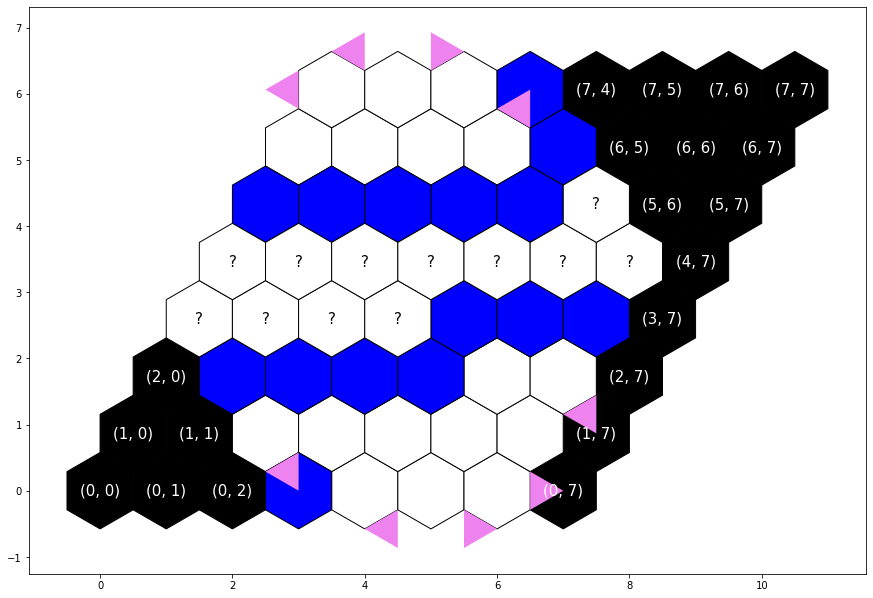

In [9]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = [15, 15]
catan = FogIsland()
catan.draw(default_gift=True)

In [6]:
resources = {
    ResourceType.Tree : 4,
    ResourceType.Grain : 3,
    ResourceType.Steel : 3,
    ResourceType.Sheep : 4,
    ResourceType.Ground : 3
}

number_dist = {
    2 : 1,
    3 : 2,
    4 : 2,
    5 : 2,
    6 : 2, 
    8 : 2,
    9 : 2,
    10 : 2,
    11 : 1,
    12 : 1
}

harbors = {
    HarborType.Tree : 1,
    HarborType.Grain : 1,
    HarborType.Steel : 1,
    HarborType.Sheep : 1,
    HarborType.Ground : 1,
    HarborType.ThreeToOne : 4,
}

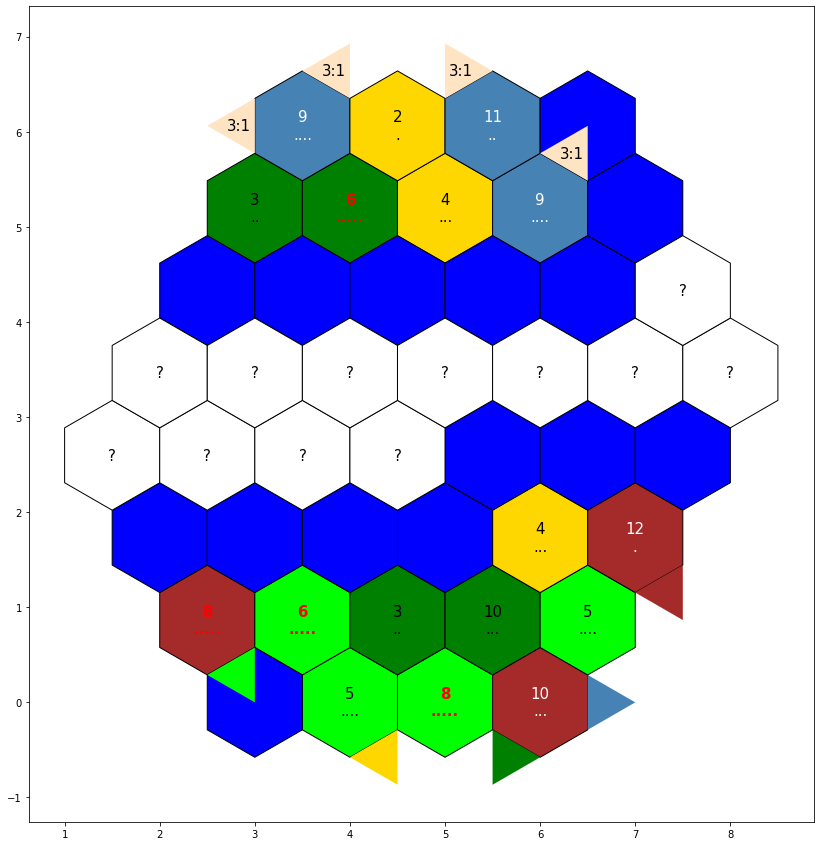

In [10]:
catan.generate(resources, number_dist, harbors)
catan.draw(default_gift=False)